# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

### Student Information

_Full Name (Last Name, First Name)_: \
_Student No._:\
_Section_:

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name:**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

In [16]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import corner
import arviz
import matplotlib.lines as mlines
par_path = os.path.abspath(os.path.join('..'))
if par_path not in sys.path:
    sys.path.append(par_path)
data_path = os.path.join(par_path, 'data')

In [17]:
#Read the csv files
LIGO = pd.read_csv(os.path.join(data_path, 'LIGO.csv'))
LISA = pd.read_csv(os.path.join(data_path, 'LISA.csv'))
ET = pd.read_csv(os.path.join(data_path, 'ET.csv'))
#Get the LIGO columns
zLIGO = LIGO[LIGO.columns[0]]
dLLIGO = LIGO[LIGO.columns[1]]
errLIGO =  LIGO[LIGO.columns[2]]
#Get the LISA columns
zLISA = LISA[LISA.columns[0]]
dLLISA = LISA[LISA.columns[1]]
errLISA = LISA[LISA.columns[2]]
#Get the ET columns
zET = ET[ET.columns[0]]
dLET = ET[ET.columns[1]]
errET = ET[ET.columns[2]]

By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

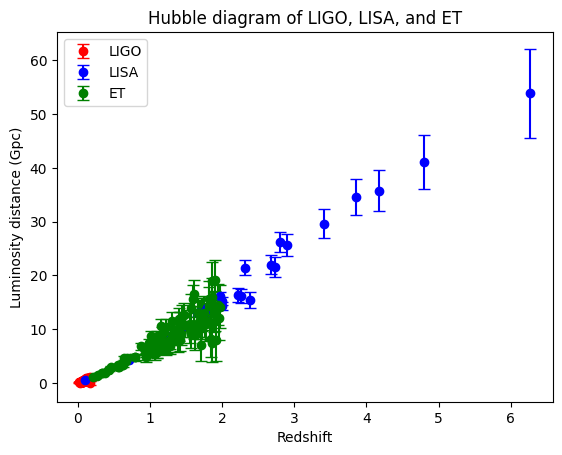

In [18]:
#Plot the hubble diagrams of the different observatories
plt.errorbar(zLIGO, dLLIGO, yerr = errLIGO, fmt = 'o', color = 'red', capsize = 4, label = 'LIGO')
plt.errorbar(zLISA, dLLISA, yerr = errLISA, fmt = 'o', color = 'blue', capsize = 4, label = 'LISA')
plt.errorbar(zET, dLET, yerr = errET, fmt = 'o', color = 'green', capsize = 4, label = 'ET')
plt.title('Hubble diagram of LIGO, LISA, and ET')
plt.xlabel('Redshift')
plt.ylabel('Luminosity distance (Gpc)')
plt.legend()
plt.show()

The diagram above shows the following interpretations:
- The LIGO observatory can only collect data with small redshift and close luminosity distances, so it might be a limiting factor later since it can only detect near objects. 
- The LISA Observatory can get information from very far objects both redshift and luminosity-distance wise, which means it can be important in augmenting the information that we know from LIGO.
- The ET observatory has a lot of data in between the ranges of LISA and LIGO, this will be helpful later in constraining our future data and making it more complete.

#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [19]:
from astropy.cosmology import FlatLambdaCDM

In [20]:
#Define chi-square and likelihood function for LIGO
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dLLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(params):
    H0, Om0 = params
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

##Define chi-square and likelihood function for LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dLLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(params):
    H0, Om0 = params
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))

#Define chi-square and likelihood function for LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zET)/1000)
    dev = (model - np.array(dLET))/np.array(errET)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISAET_lcdm(params):
    H0, Om0 = params
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0)+ chi2ET_lcdm(H0, Om0))

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can use number of walkers (nwalkers) of 6 and number of iterations (niter) of 5,000 and number of burn-in samples (nburn) of 100.


*For this part, the creator of the code was a bit paranoid of the variables changing for each of the runs so he made 3 different initial variables lol*

In [21]:
#Call the variables for the MCMC run of LIGO
import emcee as em
nwalkers = 100
ndim = 2
niter = 2000
nburn = 100
dres = [0.1, 0.003] # step size for H_0 and omega_m,0, respectively
initial = np.array([70., 0.3])
P0 = [initial + dres * np.random.randn(ndim) for i in range(nwalkers)]


In [22]:
#Initialize and run the sampler for LIGO and take the samples to be plotted for later
sampler_LIGO = em.EnsembleSampler(nwalkers, ndim, llikeLIGO_lcdm)
sampler_LIGO.run_mcmc(initial_state = P0, nsteps= niter, progress = True)
samples_LIGO = sampler_LIGO.get_chain(discard = nburn, flat = True)

100%|██████████| 2000/2000 [03:22<00:00,  9.88it/s]


In [23]:
#Call the variables for the MCMC run of LIGO+LISA
nwalkers1 = 100
ndim1 = 2
niter1 = 2000
nburn1 = 100
dres = [0.1, 0.003] # step size for H_0 and omega_m,0, respectively
initial = np.array([70., 0.3])
P1 = [initial + dres * np.random.randn(ndim1) for i in range(nwalkers1)]


In [24]:
#Initialize and run the sampler for LIGO+LISA and take the samples to be plotted for later
sampler_LISA = em.EnsembleSampler(nwalkers1, ndim1, llikeLIGOLISA_lcdm)
sampler_LISA.run_mcmc(initial_state = P1, nsteps= niter1, progress = True)
samples_LISA = sampler_LISA.get_chain(discard = nburn1, flat = True)

100%|██████████| 2000/2000 [08:25<00:00,  3.96it/s]


In [25]:
#Call the variables for the MCMC run of LIGO+LISA+ET
nwalkers2 = 100
ndim2 = 2
niter2 = 2000
nburn2 = 100
dres = [0.1, 0.003] # step size for H_0 and omega_m,0, respectively
initial = np.array([70., 0.3])
P2 = [initial + dres * np.random.randn(ndim2) for i in range(nwalkers2)]

In [26]:
#Initialize and run the sampler for LIGO+LISA+ET and take the samples to be plotted for later
sampler_ET = em.EnsembleSampler(nwalkers2, ndim2, llikeLIGOLISAET_lcdm)
sampler_ET.run_mcmc(initial_state = P2, nsteps= niter2, progress = True)
samples_ET = sampler_ET.get_chain(discard = nburn2, flat = True)

100%|██████████| 2000/2000 [12:01<00:00,  2.77it/s]


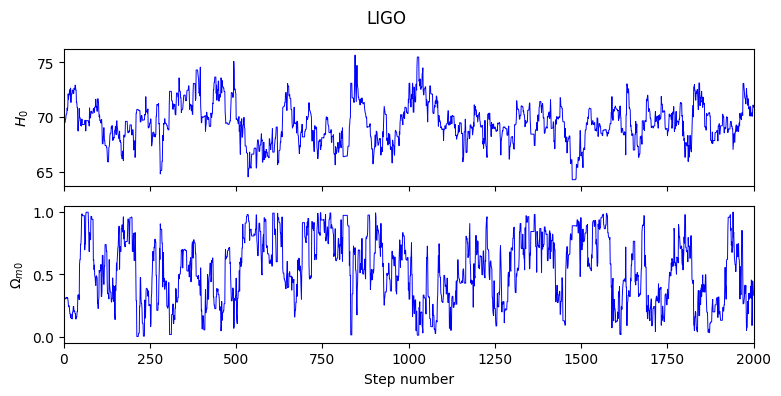

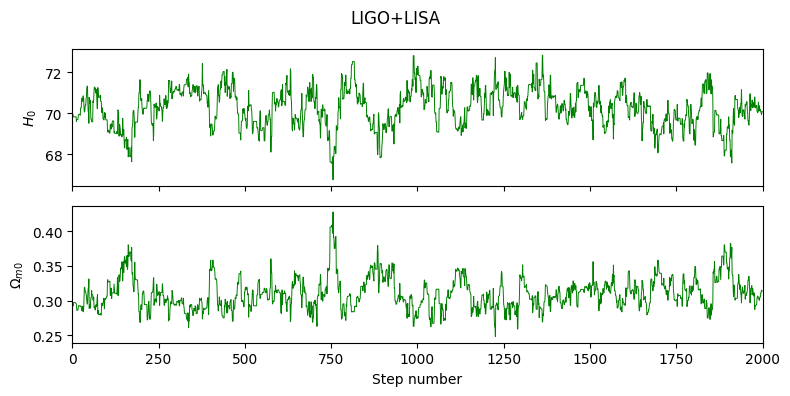

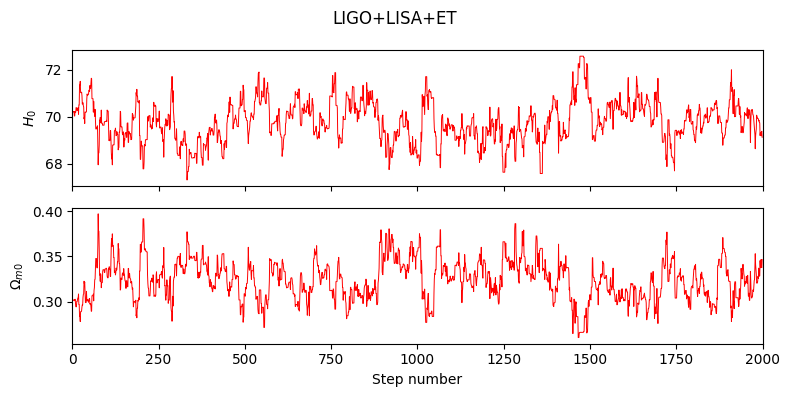

In [27]:
#Create the plot of the values of H0 and om0 throughout the simulation
params = [r'$H_0$', r'$\Omega_{m0}$']
thin, discard = 0, 2

#For LIGO
fig, axes = plt.subplots(ndim, figsize = (8, 4), sharex = True)
fig.suptitle('LIGO')
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler_LIGO.get_chain()[thin:,discard,i], color = 'blue', alpha = 1, lw =0.7)
    ax.set_xlim(0, len(sampler_LIGO.get_chain()))
    ax.set_ylabel(params[i])
axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()

#For LIGO+LISA
fig, axes = plt.subplots(ndim, figsize = (8, 4), sharex = True)
fig.suptitle('LIGO+LISA')
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler_LISA.get_chain()[thin:,discard,i], color = 'green', alpha = 1, lw =0.7)
    ax.set_xlim(0, len(sampler_LISA.get_chain()))
    ax.set_ylabel(params[i])
axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()

#For LIGO+LISA+ET
fig, axes = plt.subplots(ndim, figsize = (8, 4), sharex = True)
fig.suptitle('LIGO+LISA+ET')
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler_ET.get_chain()[thin:,discard,i], color = 'red', alpha = 1, lw =0.7)
    ax.set_xlim(0, len(sampler_ET.get_chain()))
    ax.set_ylabel(params[i])
axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()


**LIGO**

LIGO's H0 values range from 65-75 which are pretty consistent in getting the value of the Hubble constant. However, its om0 values are fluctuating from 0 to 1 which means that it cannopt predict the value of om0 effectively.

**LIGO+LISA**

Adding LISA to LIGO, the H0 values now range from 67-83, narrowing it a little bit further. But the true merit of this is that now, the value of om0 no longer fluctuates wildly from 0 to 1, now only constrained in the range 0.25-0.35

**LIGO+LISA+ET**

Lastly, adding ET to the previous plot makes both the H0 and om0 values more constrained, making the plot even more restricted and have a smaller error value

#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.

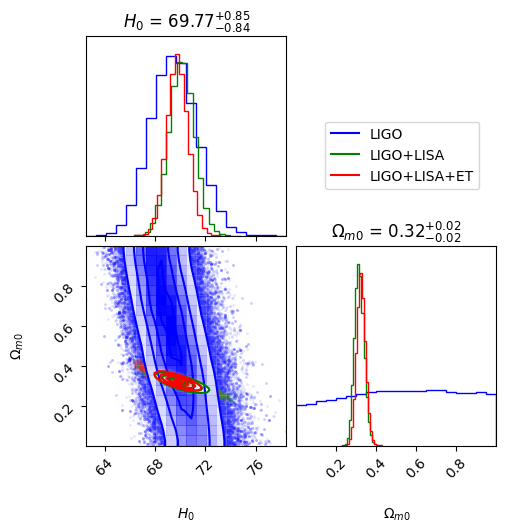

In [28]:
#Make the corner plot and superimpose all of them on top of one another
params = [r'$H_0$', r'$\Omega_{m0}$']
labels = params
fig = corner.corner(samples_LIGO, show_titles=True,labels=labels, color = 'blue', smooth = True)
fig1 = corner.corner(samples_LISA, show_titles=True,labels=labels, fig = fig, color = 'green', smooth = True)
fig2 = corner.corner(samples_ET, show_titles=True,labels=labels, fig = fig1, color = 'red', smooth = True)
blueline = mlines.Line2D([], [], color ='blue', label = 'LIGO')
greenline = mlines.Line2D([], [], color ='green', label = 'LIGO+LISA')
redline = mlines.Line2D([], [], color ='red', label = 'LIGO+LISA+ET')
plt.legend(handles = [blueline, greenline, redline], bbox_to_anchor = (0.95,1.25), loc = 4)
plt.show()

(Note that matter includes both regular matter, and dark matter, since our current model predicts that the universe is about 5% normal matter, 26% dark matter, and 69% dark energy [1])
- The top-left plot shows the approximations of each of the LIGO, LIGO+LISA, and LIGO+LISA+ET for the Hubble constant H0, this shows that all of them were able to approximate the value of the Hubble constant, albeit the LIGO is more spread out and LIGO+LISA+ET is the most constrained of all of them
- The two plots on the bottom then shows the approximations of LIGO, LIGO+LISA, and LIGO+LISA+ET for H0, the one on the left shows it vs H0, and the second one is a probability density plot of the true value of Om0. This shows that LIGO basically breaks down because in the initial plot in part 2, it was only able to detect very close objects and was not able to properly detect the effects of redshift, meanwhile, LISA and ET's observation constrained the plot to have a more specific value of the percentage of matter in the universe, about 32%.

Reference:

[1] https://chandra.harvard.edu/darkuniverse/#:~:text=Like%20the%20jelly%20beans%20in,made%20of%20familiar%20atomic%20matter.